In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import precision_score, \
    recall_score, confusion_matrix, classification_report, \
    accuracy_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay,classification_report,accuracy_score

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

%matplotlib inline

## Dataset Bank Customer Churn

In [2]:
data = pd.read_csv('churn_prediction.csv')
data.head()

,customer_id,vintage,age,gender,dependents,occupation,city,customer_nw_category,branch_code,current_balance,previous_month_end_balance,average_monthly_balance_prevQ,average_monthly_balance_prevQ2,current_month_credit,previous_month_credit,current_month_debit,previous_month_debit,current_month_balance,previous_month_balance,churn,last_transaction
0,1,2101,66,Male,0.0,self_employed,187.0,2,755,1458.71,1458.71,1458.71,1449.07,0.20,0.20,0.20,0.20,1458.71,1458.71,0,2019-05-21
1,2,2348,35,Male,0.0,self_employed,NaN,2,3214,5390.37,8704.66,7799.26,12419.41,0.56,0.56,5486.27,100.56,6496.78,8787.61,0,2019-11-01
2,4,2194,31,Male,0.0,salaried,146.0,2,41,3913.16,5815.29,4910.17,2815.94,0.61,0.61,6046.73,259.23,5006.28,5070.14,0,NaT
3,5,2329,90,NaN,NaN,self_employed,1020.0,2,582,2291.91,2291.91,2084.54,1006.54,0.47,0.47,0.47,2143.33,2291.91,1669.79,1,2019-08-06
4,6,1579,42,Male,2.0,self_employed,1494.0,3,388,927.72,1401.72,1643.31,1871.12,0.33,714.61,588.62,1538.06,1157.15,1677.16,1,2019-11-03


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28382 entries, 0 to 28381
Data columns (total 21 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   customer_id                     28382 non-null  int64  
 1   vintage                         28382 non-null  int64  
 2   age                             28382 non-null  int64  
 3   gender                          27857 non-null  object 
 4   dependents                      25919 non-null  float64
 5   occupation                      28302 non-null  object 
 6   city                            27579 non-null  float64
 7   customer_nw_category            28382 non-null  int64  
 8   branch_code                     28382 non-null  int64  
 9   current_balance                 28382 non-null  float64
 10  previous_month_end_balance      28382 non-null  float64
 11  average_monthly_balance_prevQ   28382 non-null  float64
 12  average_monthly_balance_prevQ2  

## **Exploratory Data Analysis**

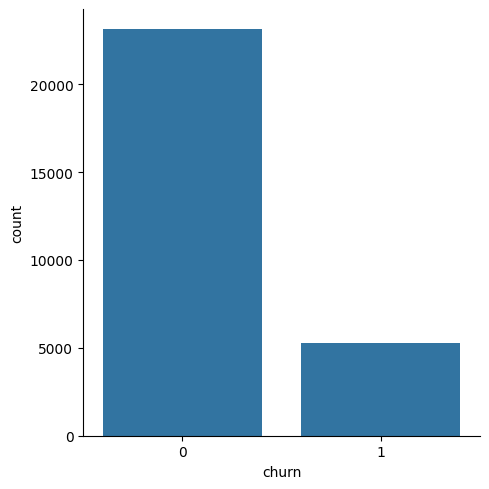

In [4]:
sns.catplot(x = "churn", kind = "count", data = data);

Here I count the number of unique values ​​in the 'churn' column and then normalize it.

In [5]:
data['churn'].value_counts(normalize=True)

0    0.814671
1    0.185329
Name: churn, dtype: float64

I can observe there imbalance case in my dataset. The imbalance in the dataset can be addressed in two ways:

- During modeling, by adding weight to the model parameters.
- After modeling, by adjusting the classification threshold to optimize metrics such as **F1-Score, precision, recall, rather than relying on accuracy, which may be biased due to the imbalance in the target dataset.**

### **Categorical Data vs Churn**

In [6]:
def proportional_aggregation(df, y, x):
    temp_df = df.groupby([y,x], as_index = False).size()
    temp_df['proportional'] = temp_df['size'] / temp_df.groupby(y)['size'].transform('sum')
    return temp_df

Here I create a "proportional aggregation" function to calculate the relative proportion of a value to the total in a category in certain data.

### Gender vs Churn

In [7]:
temp_raw = data.groupby(['churn','gender'], as_index = False).size()
temp_raw

,churn,gender,size
0,0,Female,9324
1,0,Male,13379
2,1,Female,1985
3,1,Male,3169


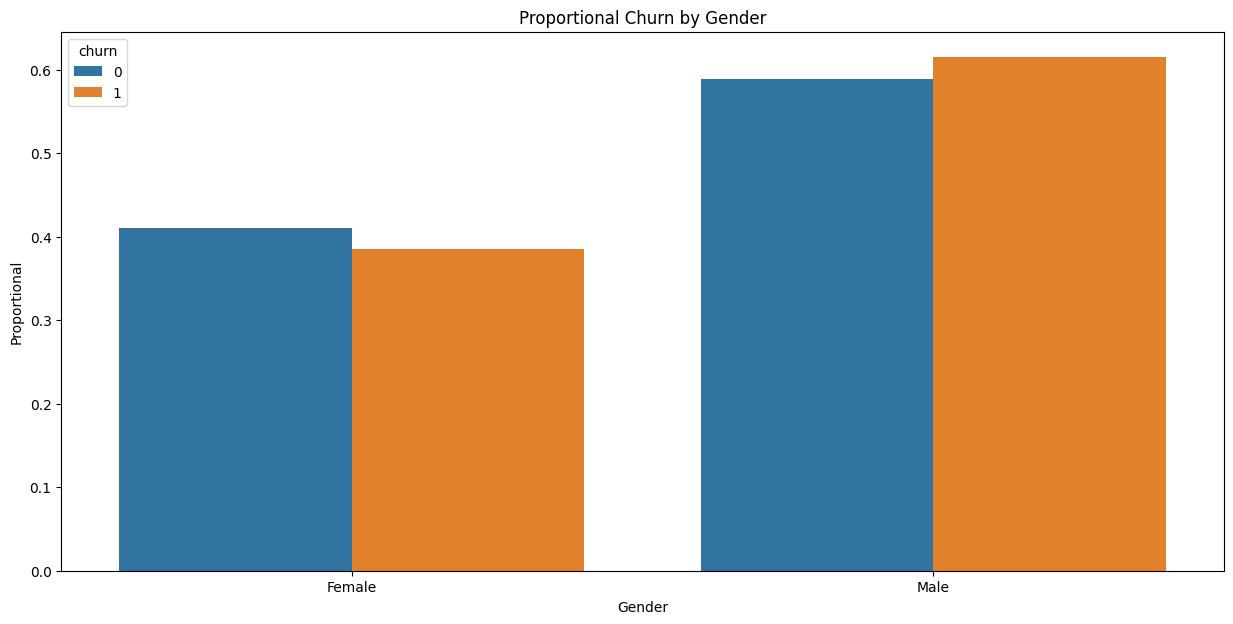

In [8]:
data_proportional = proportional_aggregation(data, "churn", "gender")

plt.figure(figsize=(15, 7))
sns.barplot(x="gender", y="proportional", hue="churn", data=data_proportional)
plt.title("Proportional Churn by Gender")
plt.ylabel("Proportional")
plt.xlabel("Gender")
plt.show()

From the bar plot above, there are 1.5 times more male accounts than female accounts.

### Occupation vs Churn

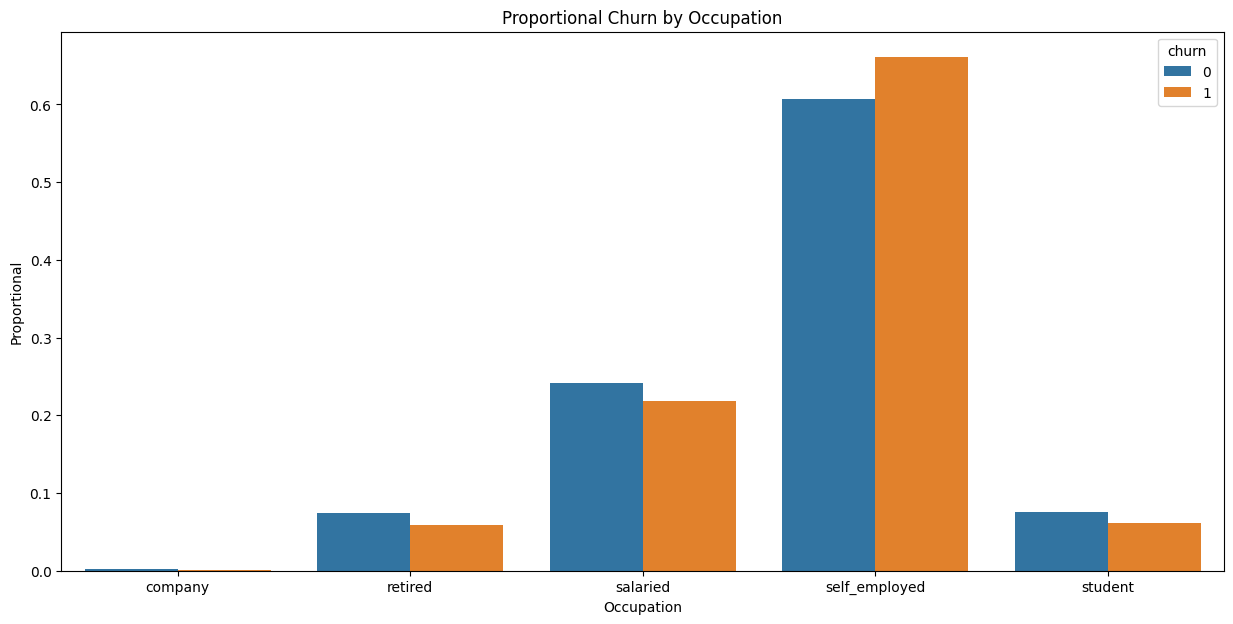

In [9]:
data_proportional = proportional_aggregation(data, "churn", "occupation")

plt.figure(figsize=(15, 7))
sns.barplot(x="occupation", y="proportional", hue="churn", data=data_proportional)
plt.title("Proportional Churn by Occupation")
plt.ylabel("Proportional")
plt.xlabel("Occupation")
plt.show()

The majority of individuals in society have jobs as self-employed. At the same time, the number of recorded corporate accounts is very small. This difference can be a focus of attention, especially when seeing transactions that are classified as outliers.

### Customer nw category vs Churn

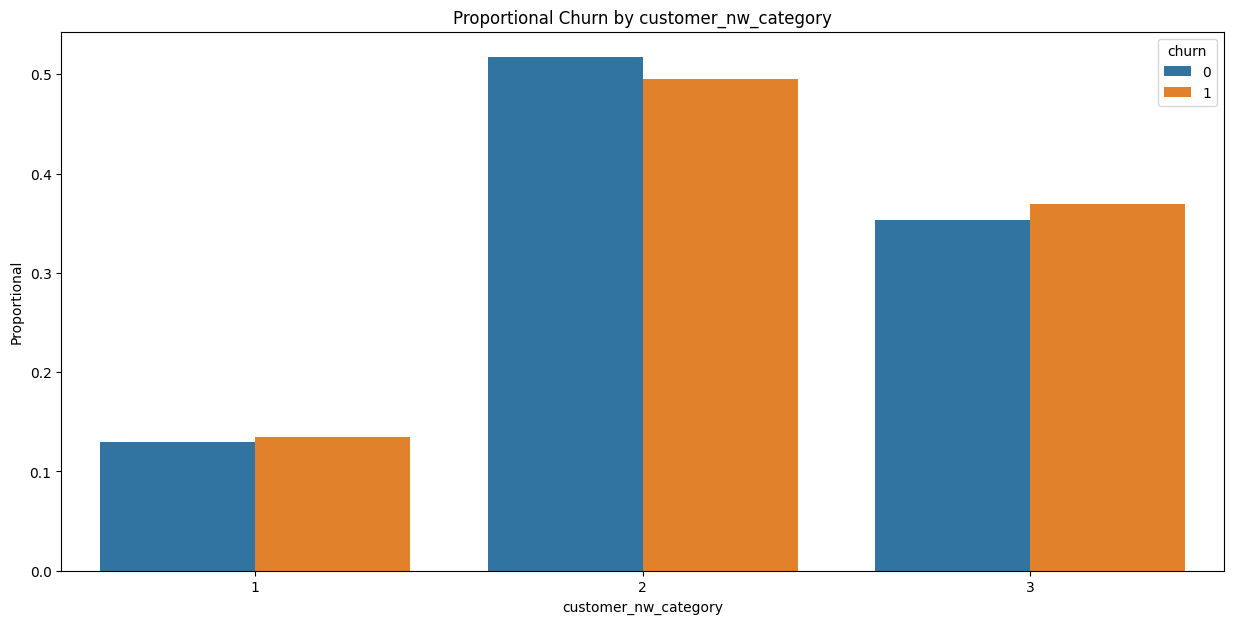

In [10]:
data_proportional = proportional_aggregation(data, "churn", "customer_nw_category")

plt.figure(figsize=(15, 7))
sns.barplot(x="customer_nw_category", y="proportional", hue="churn", data=data_proportional)
plt.title("Proportional Churn by customer_nw_category")
plt.ylabel("Proportional")
plt.xlabel("customer_nw_category")
plt.show()

Customers belonging in the Net Worth Category 2 are the most likely to churn, closely followed by customers belonging to Net Worth Category 3.

### **Numerical Data vs Churn**

### Age vs Churn

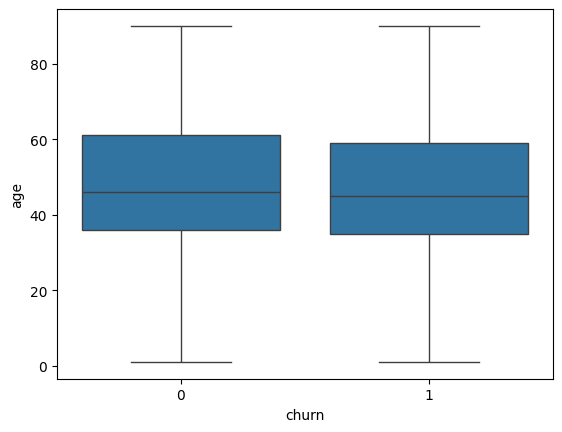

In [11]:
sns.boxplot(x = "churn", y = "age", data = data);

The age of most customers is around 30 to 60 years old.

### Vintage vs Churn

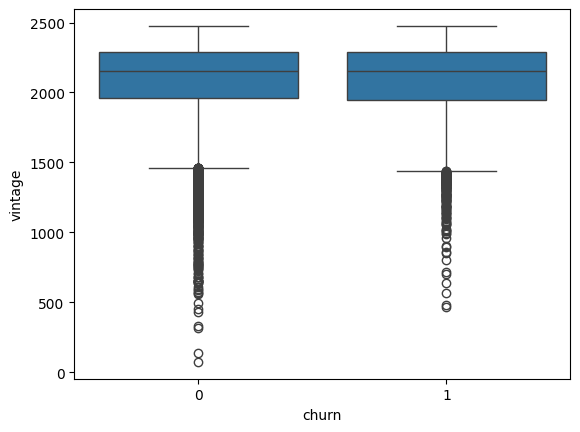

In [12]:
sns.boxplot(x = "churn", y = "vintage", data = data);

Most customers joined within a time span of approximately 2100 days from the day of data extraction. This may reflect a common registration or membership pattern over a period of time, indicating a certain trend or inclination over time.

### Current month vs Churn

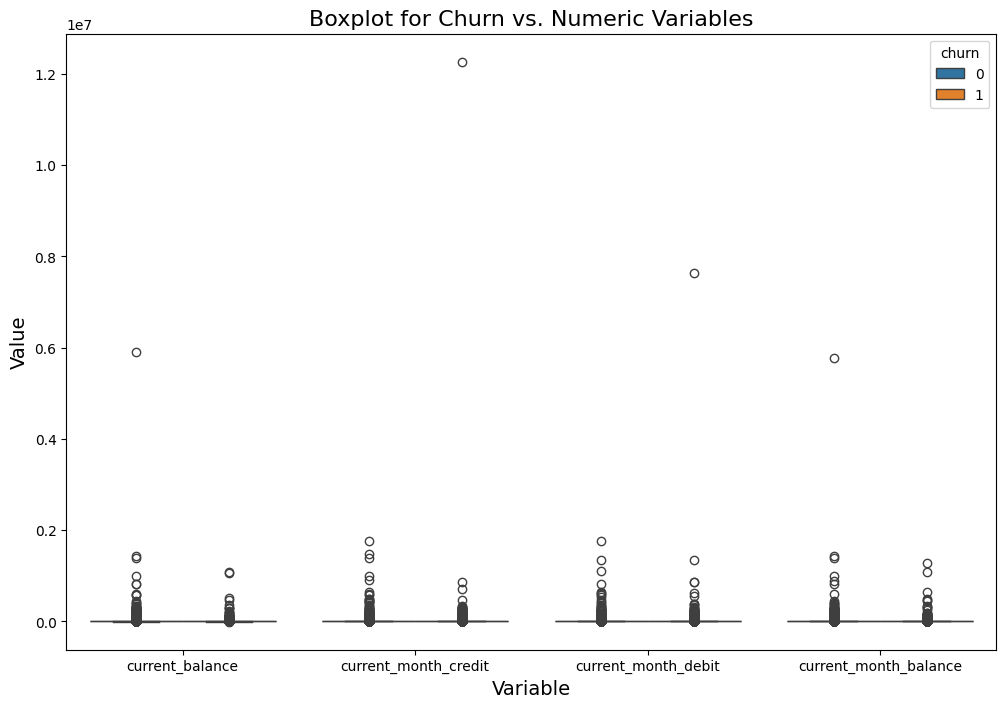

In [13]:
boxplot_data = data[['churn', 'current_balance', 'current_month_credit', 'current_month_debit', 'current_month_balance']]

plt.figure(figsize=(12, 8))
sns.boxplot(x="variable", y="value", hue="churn", data=pd.melt(boxplot_data, id_vars="churn"))
plt.xlabel('Variable', fontsize=14)
plt.ylabel('Value', fontsize=14)
plt.title('Boxplot for Churn vs. Numeric Variables', fontsize=16)
plt.show()


The above plot shows very clear outliers from all the columns against churn.

### Previous Month vs Churn

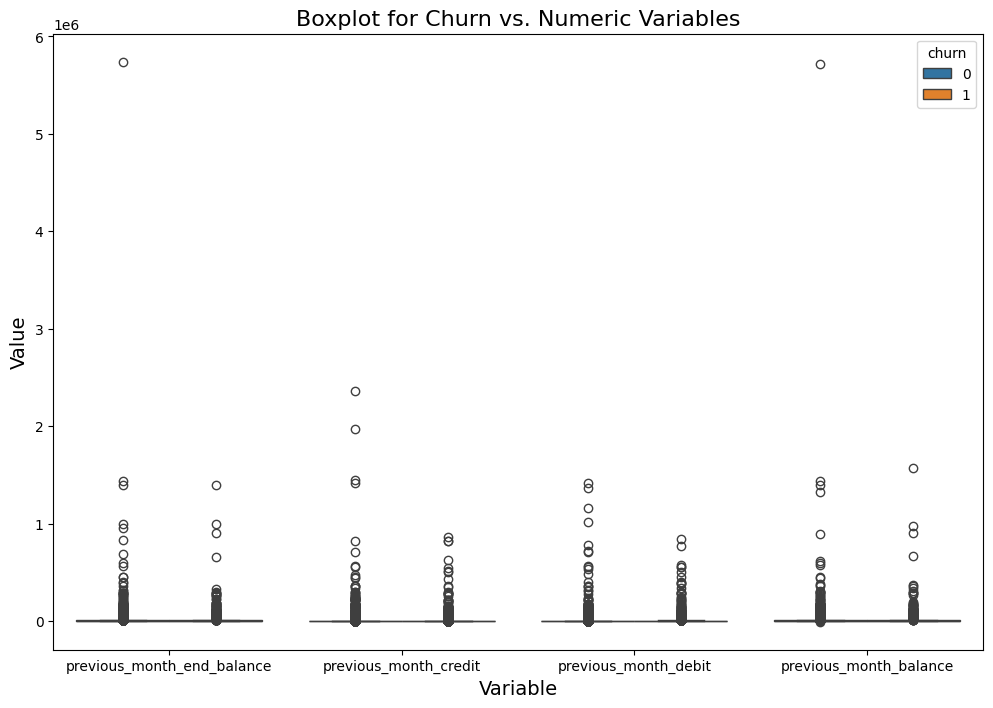

In [14]:
boxplot_data = data[['churn', 'previous_month_end_balance', 'previous_month_credit', 'previous_month_debit', 'previous_month_balance']]

plt.figure(figsize=(12, 8))
sns.boxplot(x="variable", y="value", hue="churn", data=pd.melt(boxplot_data, id_vars="churn"))
plt.xlabel('Variable', fontsize=14)
plt.ylabel('Value', fontsize=14)
plt.title('Boxplot for Churn vs. Numeric Variables', fontsize=16)
plt.show()

Here it can be seen that most customers make transactions in small amounts.

### Previous quarters vs Churn

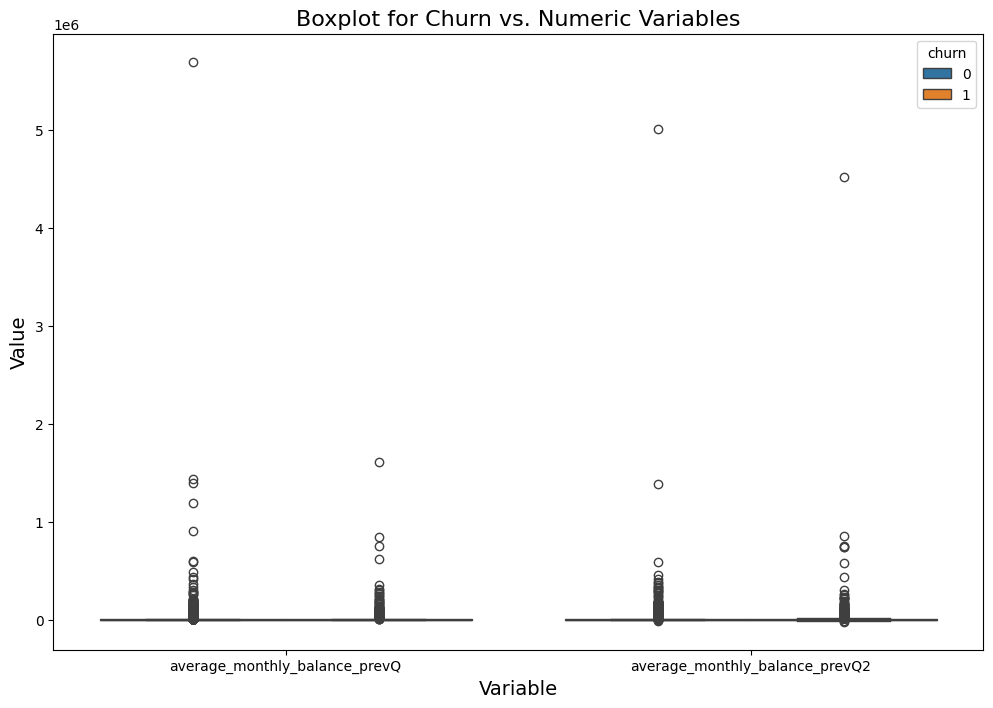

In [15]:
boxplot_data = data[['churn', 'average_monthly_balance_prevQ', 'average_monthly_balance_prevQ2']]

plt.figure(figsize=(12, 8))
sns.boxplot(x="variable", y="value", hue="churn", data=pd.melt(boxplot_data, id_vars="churn"))
plt.xlabel('Variable', fontsize=14)
plt.ylabel('Value', fontsize=14)
plt.title('Boxplot for Churn vs. Numeric Variables', fontsize=16)
plt.show()

average monthly balance prevQ and average_monthly_balance_prevQ2 look the same. What needs to be considered here is whether there are similarities between customers who make large transactions.

### **Feature Engineering**
1. Missing Value Checking
2. Encoding

In [16]:
data.shape

(28382, 21)

In [17]:
data['last_transaction'].value_counts()

NaT           3223
2019-12-31    1672
2019-12-28     831
2019-12-17     654
2019-12-27     632
2019-12-25     596
2019-12-26     576
2019-12-24     561
2019-12-20     486
2019-12-18     478
2019-12-22     476
2019-12-11     472
2019-12-10     468
2019-12-19     459
2019-12-14     447
2019-12-03     427
2019-12-12     408
2019-12-13     398
2019-12-07     398
2019-12-05     346
2019-12-08     341
2019-12-21     322
2019-12-04     318
2019-12-06     316
2019-11-26     238
2019-11-28     223
2019-11-30     218
2019-11-29     201
2019-11-21     193
2019-12-01     191
2019-11-23     184
2019-11-12     179
2019-11-13     173
2019-11-22     167
2019-11-19     164
2019-11-20     164
2019-11-08     160
2019-10-31     159
2019-11-14     153
2019-10-29     151
2019-11-15     144
2019-11-05     143
2019-11-01     136
2019-10-30     135
2019-11-06     133
2019-11-09     124
2019-11-16     117
2019-10-16     116
2019-09-27     115
2019-11-07     115
2019-11-17     114
2019-10-15     108
2019-10-01  

In [18]:
data = data[data['last_transaction'] != 'NaT'].reset_index(drop=True)

In [19]:
data['last_transaction'] = pd.to_datetime(data['last_transaction'])

date = pd.DatetimeIndex(data['last_transaction'])

data['doy_ls_tran'] = date.dayofyear
data['moy_ls_tran'] = date.month
data['dow_ls_tran'] = date.dayofweek

In [20]:
data = data.drop(columns = ['last_transaction'])
data.dtypes

customer_id                         int64
vintage                             int64
age                                 int64
gender                             object
dependents                        float64
occupation                         object
city                              float64
customer_nw_category                int64
branch_code                         int64
current_balance                   float64
previous_month_end_balance        float64
average_monthly_balance_prevQ     float64
average_monthly_balance_prevQ2    float64
current_month_credit              float64
previous_month_credit             float64
current_month_debit               float64
previous_month_debit              float64
current_month_balance             float64
previous_month_balance            float64
churn                               int64
doy_ls_tran                         int64
moy_ls_tran                         int64
dow_ls_tran                         int64
dtype: object

### Missing Value Handling

In [21]:
data.isna().sum()

customer_id                          0
vintage                              0
age                                  0
gender                             461
dependents                        2167
occupation                          68
city                               685
customer_nw_category                 0
branch_code                          0
current_balance                      0
previous_month_end_balance           0
average_monthly_balance_prevQ        0
average_monthly_balance_prevQ2       0
current_month_credit                 0
previous_month_credit                0
current_month_debit                  0
previous_month_debit                 0
current_month_balance                0
previous_month_balance               0
churn                                0
doy_ls_tran                          0
moy_ls_tran                          0
dow_ls_tran                          0
dtype: int64

There are missing values ​​in the gender, dependents, occupation, and city columns.

In [22]:
data.dropna(inplace=True)

In [23]:
data.isna().sum()

customer_id                       0
vintage                           0
age                               0
gender                            0
dependents                        0
occupation                        0
city                              0
customer_nw_category              0
branch_code                       0
current_balance                   0
previous_month_end_balance        0
average_monthly_balance_prevQ     0
average_monthly_balance_prevQ2    0
current_month_credit              0
previous_month_credit             0
current_month_debit               0
previous_month_debit              0
current_month_balance             0
previous_month_balance            0
churn                             0
doy_ls_tran                       0
moy_ls_tran                       0
dow_ls_tran                       0
dtype: int64

### Encoding

Perform one-hot encoding on categorical data in the gender and occupation columns

In [24]:
data.head()

,customer_id,vintage,age,gender,dependents,occupation,city,customer_nw_category,branch_code,current_balance,previous_month_end_balance,average_monthly_balance_prevQ,average_monthly_balance_prevQ2,current_month_credit,previous_month_credit,current_month_debit,previous_month_debit,current_month_balance,previous_month_balance,churn,doy_ls_tran,moy_ls_tran,dow_ls_tran
0,1,2101,66,Male,0.0,self_employed,187.0,2,755,1458.71,1458.71,1458.71,1449.07,0.20,0.20,0.20,0.20,1458.71,1458.71,0,141,5,1
3,6,1579,42,Male,2.0,self_employed,1494.0,3,388,927.72,1401.72,1643.31,1871.12,0.33,714.61,588.62,1538.06,1157.15,1677.16,1,307,11,6
4,7,1923,42,Female,0.0,self_employed,1096.0,2,1666,15202.20,16059.34,15211.29,13798.82,0.36,0.36,857.50,286.07,15719.44,15349.75,0,305,11,4
5,8,2048,72,Male,0.0,retired,1020.0,1,1,7006.93,7714.19,7859.74,11232.37,0.64,0.64,1299.64,439.26,7076.06,7755.98,0,267,9,1
6,9,2009,46,Male,0.0,self_employed,623.0,2,317,10096.58,8519.53,6511.82,16314.17,0.27,0.27,443.13,5688.44,8563.84,5317.04,0,193,7,4


In [25]:
data = pd.get_dummies(data, drop_first=True, dtype=int)
data.head()

,customer_id,vintage,age,dependents,city,customer_nw_category,branch_code,current_balance,previous_month_end_balance,average_monthly_balance_prevQ,average_monthly_balance_prevQ2,current_month_credit,previous_month_credit,current_month_debit,previous_month_debit,current_month_balance,previous_month_balance,churn,doy_ls_tran,moy_ls_tran,dow_ls_tran,gender_Male,occupation_retired,occupation_salaried,occupation_self_employed,occupation_student
0,1,2101,66,0.0,187.0,2,755,1458.71,1458.71,1458.71,1449.07,0.20,0.20,0.20,0.20,1458.71,1458.71,0,141,5,1,1,0,0,1,0
3,6,1579,42,2.0,1494.0,3,388,927.72,1401.72,1643.31,1871.12,0.33,714.61,588.62,1538.06,1157.15,1677.16,1,307,11,6,1,0,0,1,0
4,7,1923,42,0.0,1096.0,2,1666,15202.20,16059.34,15211.29,13798.82,0.36,0.36,857.50,286.07,15719.44,15349.75,0,305,11,4,0,0,0,1,0
5,8,2048,72,0.0,1020.0,1,1,7006.93,7714.19,7859.74,11232.37,0.64,0.64,1299.64,439.26,7076.06,7755.98,0,267,9,1,1,1,0,0,0
6,9,2009,46,0.0,623.0,2,317,10096.58,8519.53,6511.82,16314.17,0.27,0.27,443.13,5688.44,8563.84,5317.04,0,193,7,4,1,0,0,1,0


In [26]:
data.rename(columns={'gender_Male': 'gender'}, inplace=True)
data.head()

,customer_id,vintage,age,dependents,city,customer_nw_category,branch_code,current_balance,previous_month_end_balance,average_monthly_balance_prevQ,average_monthly_balance_prevQ2,current_month_credit,previous_month_credit,current_month_debit,previous_month_debit,current_month_balance,previous_month_balance,churn,doy_ls_tran,moy_ls_tran,dow_ls_tran,gender,occupation_retired,occupation_salaried,occupation_self_employed,occupation_student
0,1,2101,66,0.0,187.0,2,755,1458.71,1458.71,1458.71,1449.07,0.20,0.20,0.20,0.20,1458.71,1458.71,0,141,5,1,1,0,0,1,0
3,6,1579,42,2.0,1494.0,3,388,927.72,1401.72,1643.31,1871.12,0.33,714.61,588.62,1538.06,1157.15,1677.16,1,307,11,6,1,0,0,1,0
4,7,1923,42,0.0,1096.0,2,1666,15202.20,16059.34,15211.29,13798.82,0.36,0.36,857.50,286.07,15719.44,15349.75,0,305,11,4,0,0,0,1,0
5,8,2048,72,0.0,1020.0,1,1,7006.93,7714.19,7859.74,11232.37,0.64,0.64,1299.64,439.26,7076.06,7755.98,0,267,9,1,1,1,0,0,0
6,9,2009,46,0.0,623.0,2,317,10096.58,8519.53,6511.82,16314.17,0.27,0.27,443.13,5688.44,8563.84,5317.04,0,193,7,4,1,0,0,1,0


In [27]:
data = data.drop(["customer_id"], axis = 1)

The customer_id variable here can be omitted because it is a unique identifier for each entity in the dataset.

### Train Test Split

In [28]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(data, test_size = 0.2, random_state=42)

In [29]:
test.head()

,vintage,age,dependents,city,customer_nw_category,branch_code,current_balance,previous_month_end_balance,average_monthly_balance_prevQ,average_monthly_balance_prevQ2,current_month_credit,previous_month_credit,current_month_debit,previous_month_debit,current_month_balance,previous_month_balance,churn,doy_ls_tran,moy_ls_tran,dow_ls_tran,gender,occupation_retired,occupation_salaried,occupation_self_employed,occupation_student
13548,2165,21,0.0,1020.0,1,13,1221.42,1309.32,4459.98,1089.54,63.19,33.91,298.23,8056.13,1241.82,4814.67,1,354,12,4,1,0,0,0,1
8277,2243,34,0.0,1565.0,2,4394,7190.29,7394.44,7373.64,5256.13,0.20,0.20,9.36,0.20,7332.03,7394.44,0,215,8,5,0,0,0,1,0
16578,1949,52,0.0,578.0,3,758,2291.57,442.64,2172.26,3418.31,1848.96,0.03,0.03,0.03,1717.77,1274.70,0,346,12,3,0,0,1,0,0
11614,2012,49,2.0,834.0,1,382,2635.57,4611.47,1840.85,1560.48,0.30,3774.02,1976.20,17.44,3113.11,1296.31,0,334,11,5,1,0,1,0,0
17975,1830,28,0.0,409.0,2,2074,2610.74,2610.74,2240.54,1272.60,0.51,0.51,0.51,0.51,2610.74,2449.45,0,222,8,5,0,0,0,1,0


In [30]:
X_train = train.drop(columns=['churn'])
y_train = train['churn']

X_test = test.drop(columns=['churn'])
y_test = test['churn']

## Defining Models
Here I use 4 models, namely:
1. Logistic Regression
2. KNN
3. Decision Tree
4. SVM

In [31]:
y_train.value_counts(normalize=True)

0    0.807172
1    0.192828
Name: churn, dtype: float64

### Logistic Regression

In [32]:
logistic_model = LogisticRegression(
    random_state = 42,
    class_weight = {0: 0.192828, 1:0.807172}
)

### KNN

In [33]:
knn_clf = KNeighborsClassifier()

### Decision Tree

In [34]:
dt_clf = DecisionTreeClassifier(
    random_state = 42,
    class_weight = {0: 0.192828, 1:0.807172}
)

### SVM

In [35]:
svm_clf = SVC(
    random_state = 42,
    probability=True,
    class_weight = {0: 0.192828, 1:0.807172}
)

## Fitting Model to Data

### Logistic Regression

In [36]:
logistic_model.fit(X_train, y_train)

c:\Users\M S I\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(class_weight={0: 0.192828, 1: 0.807172}, random_state=42)

### KNN

In [37]:
knn_clf.fit(X_train, y_train)

KNeighborsClassifier()

### Decision Tree

In [38]:
dt_clf.fit(X_train, y_train)

DecisionTreeClassifier(class_weight={0: 0.192828, 1: 0.807172}, random_state=42)

### SVM

In [39]:
svm_clf.fit(X_train, y_train)

SVC(class_weight={0: 0.192828, 1: 0.807172}, probability=True, random_state=42)

## Model Evaluation

In [40]:
def evaluate(model, x_test = X_test, y_test = y_test, x_train=X_train, y_train=y_train):
    y_pred_train = model.predict(x_train)
    print('======= Data Train =======')
    print('------')
    print('Confusion Matrix Data Train:')
    print()
    print(classification_report(y_train, y_pred_train))
    print('------')

    tn, fp, fn, tp = confusion_matrix(y_train, y_pred_train).ravel()
    print('Assuming 1 as positive, we get for Data Train:')
    print('')
    print('True Positive:', tp)
    print('True Negative:', tn)
    print('False Positive:', fp)
    print('False Negative:', fn)

    print('')

    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    print('Accuracy Data Train:', accuracy_score(y_train, y_pred_train))
    print('Precision Data Train:', precision)
    print('Recall Data Train:', recall)
    print('F1-Score Data Train:', 2 * (precision * recall)/(precision + recall))

    y_pred = model.predict(x_test)
    print('======= Data Test =======')
    print('------')
    print('Confusion Matrix:')
    print()
    print(classification_report(y_test, y_pred))
    print('------')

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    print('Assuming 1 as positive, we get:')
    print('')
    print('True Positive:', tp)
    print('True Negative:', tn)
    print('False Positive:', fp)
    print('False Negative:', fn)

    print('')

    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    print('Accuracy:', accuracy_score(y_test, y_pred))
    print('Precision Data Test:', precision)
    print('Recall Data Test:', recall)
    print('F1-Score Data Test:', 2 * (precision * recall)/(precision + recall))

In [41]:
X_train.shape

(17653, 24)

In [42]:
X_test.shape

(4414, 24)

### Evaluation Using Confusion Matrix

### Logistic Regression Evaluation

In [43]:
evaluate(logistic_model, x_test = X_test, y_test = y_test, x_train=X_train, y_train=y_train)

======= Data Train =======
------
Confusion Matrix Data Train:

              precision    recall  f1-score   support

           0       0.90      0.80      0.85     14249
           1       0.43      0.62      0.50      3404

    accuracy                           0.77     17653
   macro avg       0.66      0.71      0.68     17653
weighted avg       0.81      0.77      0.78     17653

------
Assuming 1 as positive, we get for Data Train:

True Positive: 2094
True Negative: 11433
False Positive: 2816
False Negative: 1310

Accuracy Data Train: 0.7662720217526766
Precision Data Train: 0.4264765784114053
Recall Data Train: 0.6151586368977673
F1-Score Data Train: 0.5037286504690882
======= Data Test =======
------
Confusion Matrix:

              precision    recall  f1-score   support

           0       0.89      0.80      0.84      3544
           1       0.41      0.59      0.49       870

    accuracy                           0.76      4414
   macro avg       0.65      0.69      0.

### KNN Evaluation

In [44]:
evaluate(knn_clf, x_test = X_test.values, y_test = y_test, x_train=X_train.values, y_train=y_train)

c:\Users\M S I\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


======= Data Train =======
------
Confusion Matrix Data Train:

              precision    recall  f1-score   support

           0       0.89      0.97      0.93     14249
           1       0.78      0.49      0.60      3404

    accuracy                           0.87     17653
   macro avg       0.83      0.73      0.76     17653
weighted avg       0.87      0.87      0.86     17653

------
Assuming 1 as positive, we get for Data Train:

True Positive: 1663
True Negative: 13776
False Positive: 473
False Negative: 1741

Accuracy Data Train: 0.8745822239845918
Precision Data Train: 0.778558052434457
Recall Data Train: 0.48854289071680373
F1-Score Data Train: 0.6003610108303249
======= Data Test =======
------
Confusion Matrix:



c:\Users\M S I\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


              precision    recall  f1-score   support

           0       0.86      0.94      0.90      3544
           1       0.60      0.37      0.45       870

    accuracy                           0.83      4414
   macro avg       0.73      0.65      0.68      4414
weighted avg       0.81      0.83      0.81      4414

------
Assuming 1 as positive, we get:

True Positive: 318
True Negative: 3334
False Positive: 210
False Negative: 552

Accuracy: 0.8273674671499773
Precision Data Test: 0.6022727272727273
Recall Data Test: 0.36551724137931035
F1-Score Data Test: 0.45493562231759654


### Decision Tree Evaluation

In [45]:
evaluate(dt_clf, x_test = X_test, y_test = y_test, x_train=X_train, y_train=y_train)

======= Data Train =======
------
Confusion Matrix Data Train:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     14249
           1       1.00      1.00      1.00      3404

    accuracy                           1.00     17653
   macro avg       1.00      1.00      1.00     17653
weighted avg       1.00      1.00      1.00     17653

------
Assuming 1 as positive, we get for Data Train:

True Positive: 3404
True Negative: 14249
False Positive: 0
False Negative: 0

Accuracy Data Train: 1.0
Precision Data Train: 1.0
Recall Data Train: 1.0
F1-Score Data Train: 1.0
======= Data Test =======
------
Confusion Matrix:

              precision    recall  f1-score   support

           0       0.86      0.86      0.86      3544
           1       0.44      0.44      0.44       870

    accuracy                           0.78      4414
   macro avg       0.65      0.65      0.65      4414
weighted avg       0.78      0.78      0.78      4414

### SVM Evaluation

In [46]:
evaluate(svm_clf, x_test = X_test.values, y_test = y_test, x_train=X_train.values, y_train=y_train)

c:\Users\M S I\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


======= Data Train =======
------
Confusion Matrix Data Train:

              precision    recall  f1-score   support

           0       0.87      0.89      0.88     14249
           1       0.51      0.46      0.48      3404

    accuracy                           0.81     17653
   macro avg       0.69      0.68      0.68     17653
weighted avg       0.80      0.81      0.81     17653

------
Assuming 1 as positive, we get for Data Train:

True Positive: 1574
True Negative: 12715
False Positive: 1534
False Negative: 1830

Accuracy Data Train: 0.8094374893785758
Precision Data Train: 0.5064350064350064
Recall Data Train: 0.46239717978848416
F1-Score Data Train: 0.4834152334152334


c:\Users\M S I\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


======= Data Test =======
------
Confusion Matrix:

              precision    recall  f1-score   support

           0       0.87      0.88      0.87      3544
           1       0.48      0.45      0.46       870

    accuracy                           0.79      4414
   macro avg       0.67      0.66      0.67      4414
weighted avg       0.79      0.79      0.79      4414

------
Assuming 1 as positive, we get:

True Positive: 391
True Negative: 3117
False Positive: 427
False Negative: 479

Accuracy: 0.7947439963751699
Precision Data Test: 0.4779951100244499
Recall Data Test: 0.4494252873563218
F1-Score Data Test: 0.4632701421800947


### Create a dataframe from the evaluation results of all models.

In [47]:
def evaluate_model(model, x_train, y_train, x_test, y_test, model_name, evaluation_df):

    y_pred = model.predict(x_train)

    accuracy = accuracy_score(y_train, y_pred)
    precision = precision_score(y_train, y_pred)
    recall = recall_score(y_train, y_pred)
    f1 = f1_score(y_train, y_pred)

    result = pd.DataFrame({
        'Model': [model_name + ' - Train'],
        'Accuracy': [accuracy],
        'Precision': [precision],
        'Recall': [recall],
        'F1-Score': [f1]
    })

    evaluation_df = pd.concat([evaluation_df, result], ignore_index=True)

    y_pred = model.predict(x_test)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    result = pd.DataFrame({
        'Model': [model_name + ' - Test'],
        'Accuracy': [accuracy],
        'Precision': [precision],
        'Recall': [recall],
        'F1-Score': [f1]
    })

    evaluation_df = pd.concat([evaluation_df, result], ignore_index=True)

    return evaluation_df

In [48]:
evaluation_df = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score'])
evaluation_df = evaluate_model(logistic_model, X_train,y_train,
                               X_test,y_test,'LogReg',evaluation_df)
evaluation_df = evaluate_model(knn_clf, X_train,y_train,
                               X_test,y_test,'knn',evaluation_df)
evaluation_df = evaluate_model(dt_clf, X_train,y_train,
                               X_test,y_test,'dt',evaluation_df)
evaluation_df = evaluate_model(svm_clf, X_train,y_train,
                               X_test,y_test,'svm',evaluation_df)
evaluation_df

,Model,Accuracy,Precision,Recall,F1-Score
0,LogReg - Train,0.766272,0.426477,0.615159,0.503729
1,LogReg - Test,0.755324,0.414773,0.587356,0.486204
2,knn - Train,0.874582,0.778558,0.488543,0.600361
3,knn - Test,0.827367,0.602273,0.365517,0.454936
4,dt - Train,1.000000,1.000000,1.000000,1.000000
5,dt - Test,0.777073,0.435811,0.444828,0.440273
6,svm - Train,0.809437,0.506435,0.462397,0.483415
7,svm - Test,0.794744,0.477995,0.449425,0.463270


From the results of the 4 models above, it can be seen that the better recall is logistic regression with a train of 61.51% and a test of 58.73%, as well as the F1-score.
Then I use logistic regression to calculate the potential profit of the business.

## Cumulative Gain Plot

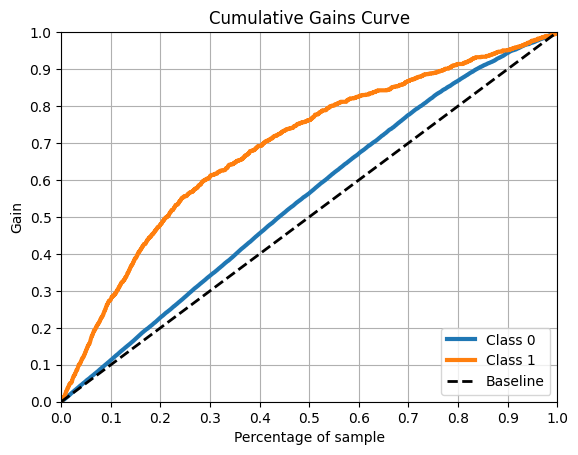

In [49]:
import scikitplot as skplt
import matplotlib.pyplot as plt
import numpy as np

skplt.metrics.plot_cumulative_gain(y_test, logistic_model.predict_proba(X_test))

plt.xticks(np.arange(0.0, 1.1, 0.1))
plt.yticks(np.arange(0.0, 1.1, 0.1))
plt.grid(True)
plt.show()


## Lift Chart

<Axes: title={'center': 'Lift Curve'}, xlabel='Percentage of sample', ylabel='Lift'>

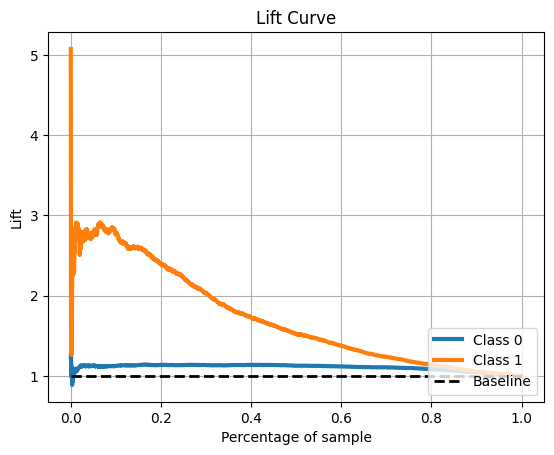

In [50]:
skplt.metrics.plot_lift_curve(y_test, logistic_model.predict_proba(X_test))

## Customer Churn Prediction Model Performance

In [51]:
from sklearn.metrics import confusion_matrix
def value_prediction(y_actual, y_prediction):
    tn, fp, fn, tp = confusion_matrix(y_actual, y_prediction).ravel()
    print('TN :',tn)
    print('TP :',tp)
    print('FN :',fn)
    print('FP :',fp)

In [52]:
value_prediction(y_test, logistic_model.predict(X_test))

TN : 2823
TP : 511
FN : 359
FP : 721


In [53]:
def get_value(y_actual, y_prediction):
    tn, fp, fn, tp = confusion_matrix(y_actual, y_prediction).ravel()
    return tn, fp, fn, tp

In [54]:
tn, fp, fn,tp = get_value(y_test, logistic_model.predict(X_test))
class_1 = tp+fp
print('AI-ML class 1 prediction (churn) :', class_1)
class_0 = tn+fn
print('AI-ML class 0 prediction (No churn) :', class_0)

AI-ML class 1 prediction (churn) : 1232
AI-ML class 0 prediction (No churn) : 3182


In [55]:
y_pred = pd.DataFrame(logistic_model.predict(X_test))
y_pred.value_counts()

0    3182
1    1232
dtype: int64

In [56]:
print('total data on X_test :', 1225+3189)

total data on X_test : 4414


In [57]:
print(f'Total population: {len(X_test)} people')
print(f'45% sample of the entire class 1 and 0: {0.45 * len(X_test)} people')
print(f'Number of % responders (Gain) who are likely to churn: {0.75 * class_1} people')

Total population: 4414 people
45% sample of the entire class 1 and 0: 1986.3 people
Number of % responders (Gain) who are likely to churn: 924.0 people


In [58]:
print('1 = person who churned')
print('0 = person who did not churn')
print('But in fact, after we conducted promotions over a certain period, we obtained the following results:')
y_test.value_counts()

1 = person who churned
0 = person who did not churn
But in fact, after we conducted promotions over a certain period, we obtained the following results:


0    3544
1     870
Name: churn, dtype: int64

In [59]:
print(f'In fact, the number of people who did not churn (Failed Prediction): {0.75 * class_1 - 870} people')
print(f'The actual number of people who churned is: {870} people')
print('Moreover, according to the lift chart, with a 45% sample, we achieved almost 1.5x better performance compared to random sampling from the prediction results')

In fact, the number of people who did not churn (Failed Prediction): 54.0 people
The actual number of people who churned is: 870 people
Moreover, according to the lift chart, with a 45% sample, we achieved almost 1.5x better performance compared to random sampling from the prediction results


In [60]:
#data actual
np.array(y_test)

array([1, 0, 0, ..., 0, 0, 0], dtype=int64)

In [61]:
#Value Prediction
logistic_model.predict(X_test)

array([1, 0, 0, ..., 1, 0, 0], dtype=int64)

### Random sampling performance (random sampling of customers who are likely to churn)

In [62]:
# From the gain chart above, if we take a 45% sample, we will get 45% of the churn customer respondents
# Thus, the potential results are:

print(f'The number of people who churn: {0.45 * class_1} people')
print(f'Actually, the number of people who did not churn (Failed Prediction): {0.45 * class_1 - 870} people')
print(f'With the potential lift chart being 1x, based on a random sample from the prediction results')

The number of people who churn: 554.4 people
Actually, the number of people who did not churn (Failed Prediction): -315.6 people
With the potential lift chart being 1x, based on a random sample from the prediction results


### Linkedin Post Links : https://www.linkedin.com/posts/naurah-nazhifah-73a936234_google-colaboratory-activity-7164603251240132608-NMPG?utm_source=share&utm_medium=member_desktop